In [1]:
# 필요한 라이브러리 임포트
import os
import json
from PIL import Image, ExifTags, ImageOps
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import regularizers
import matplotlib.pyplot as plt  # matplotlib 라이브러리 import

In [2]:
# 새로운 이미지 크기
new_size = (270, 480)

In [3]:
def preprocess_data(json_files, img_directory, new_size):  
    images = []  
    labels = []  

    for json_file in json_files:  
        with open(json_file, 'r') as f:  
            data = json.load(f)  

        img_file = data['imagePath']  
        img_path = os.path.join(img_directory, img_file)  

        img = Image.open(img_path)  
        img = ImageOps.exif_transpose(img)

        original_size = np.array(img).shape[:2]
        img = np.array(img)
        img = cv2.resize(img, new_size)  

        resize_ratio = (new_size[0] / original_size[1], new_size[1] / original_size[0])  # width, height
                
        for shape in data['shapes']:  
            if shape['label'] == 'tom_flower_poly':  
                points = np.array(shape['points'], np.float32)
                points[:, 0] *= resize_ratio[0]  # width
                points[:, 1] *= resize_ratio[1]  # height
                points = points.astype(np.int32)

                cv2.polylines(img, [points], True, (255, 255, 255), 2)  # 색 테두리 추가

        plt.imshow(img)  
        plt.title('Image with Polygons')  
        #plt.show() 이미지를 보고싶다면 주석을 제거 

        images.append(img)  
        labels.append(1 if len([shape for shape in data['shapes'] if shape['label'] == 'tom_flower_poly']) >= 3 else 0)  

    images = np.array(images)  
    labels = np.array(labels)  
    return images, labels

In [4]:
# 모델 생성 함수
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(new_size[1], new_size[0], 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    Dropout(0.5)
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    Dropout(0.5)
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    Dropout(0.5)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [5]:
# 데이터 디렉토리
directory = 'E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/라벨링데이터/f.만개꽃'  
json_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')]
json_files = json_files[:4000]

img_directory = 'E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/원천데이터/f.만개꽃/'  

# 데이터 디렉토리 리스트
directories = ['E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/라벨링데이터/f.만개꽃',
               'E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/라벨링데이터/d1.꽃(개화군)']

# 각 디렉토리에서 JSON 파일 불러오기
json_files = []
for directory in directories:
    json_files.extend([os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.json')])

# 이미지 디렉토리 리스트
img_directories = ['E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/원천데이터/f.만개꽃',
                   'E:/tomato_label/097.지능형_스마트팜_통합_데이터(토마토)/01.데이터/1.Training/원천데이터/d1.꽃(개화군)']

# 각 디렉토리에서 이미지 파일 불러오기
img_files = []
for img_directory in img_directories:
    img_files.extend([os.path.join(img_directory, file) for file in os.listdir(img_directory) if file.endswith('.jpg')])

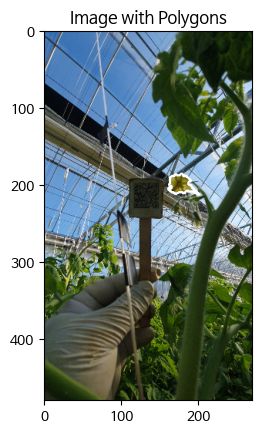

In [6]:
# 데이터 전처리
images, labels = preprocess_data(json_files, img_directory, new_size)

# 데이터 분할
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.4, random_state=42)

In [7]:
# 모델 생성
model = create_model()

In [8]:
# 모델 학습
model.fit(train_images, train_labels, epochs=3, batch_size=32, validation_data=(test_images, test_labels))

# 라벨별 데이터 개수 출력
unique, counts = np.unique(labels, return_counts=True)
label_counts = dict(zip(unique, counts))

for label, count in label_counts.items():
    print(f"Label {label}: {count}개")

Epoch 1/3


28/28 [==============================] - 40s 1s/step - loss: 2413.7234 - accuracy: 0.7268 - val_loss: 3.2201 - val_accuracy: 0.7925
Epoch 2/3
28/28 [==============================] - 39s 1s/step - loss: 0.5722 - accuracy: 0.8707 - val_loss: 0.8564 - val_accuracy: 0.7636
Epoch 3/3
28/28 [==============================] - 39s 1s/step - loss: 0.0558 - accuracy: 0.9887 - val_loss: 1.3359 - val_accuracy: 0.7942
Label 0: 1205개
Label 1: 265개


1/1 [==============================] - 0s 44ms/step
(478, 268, 32)


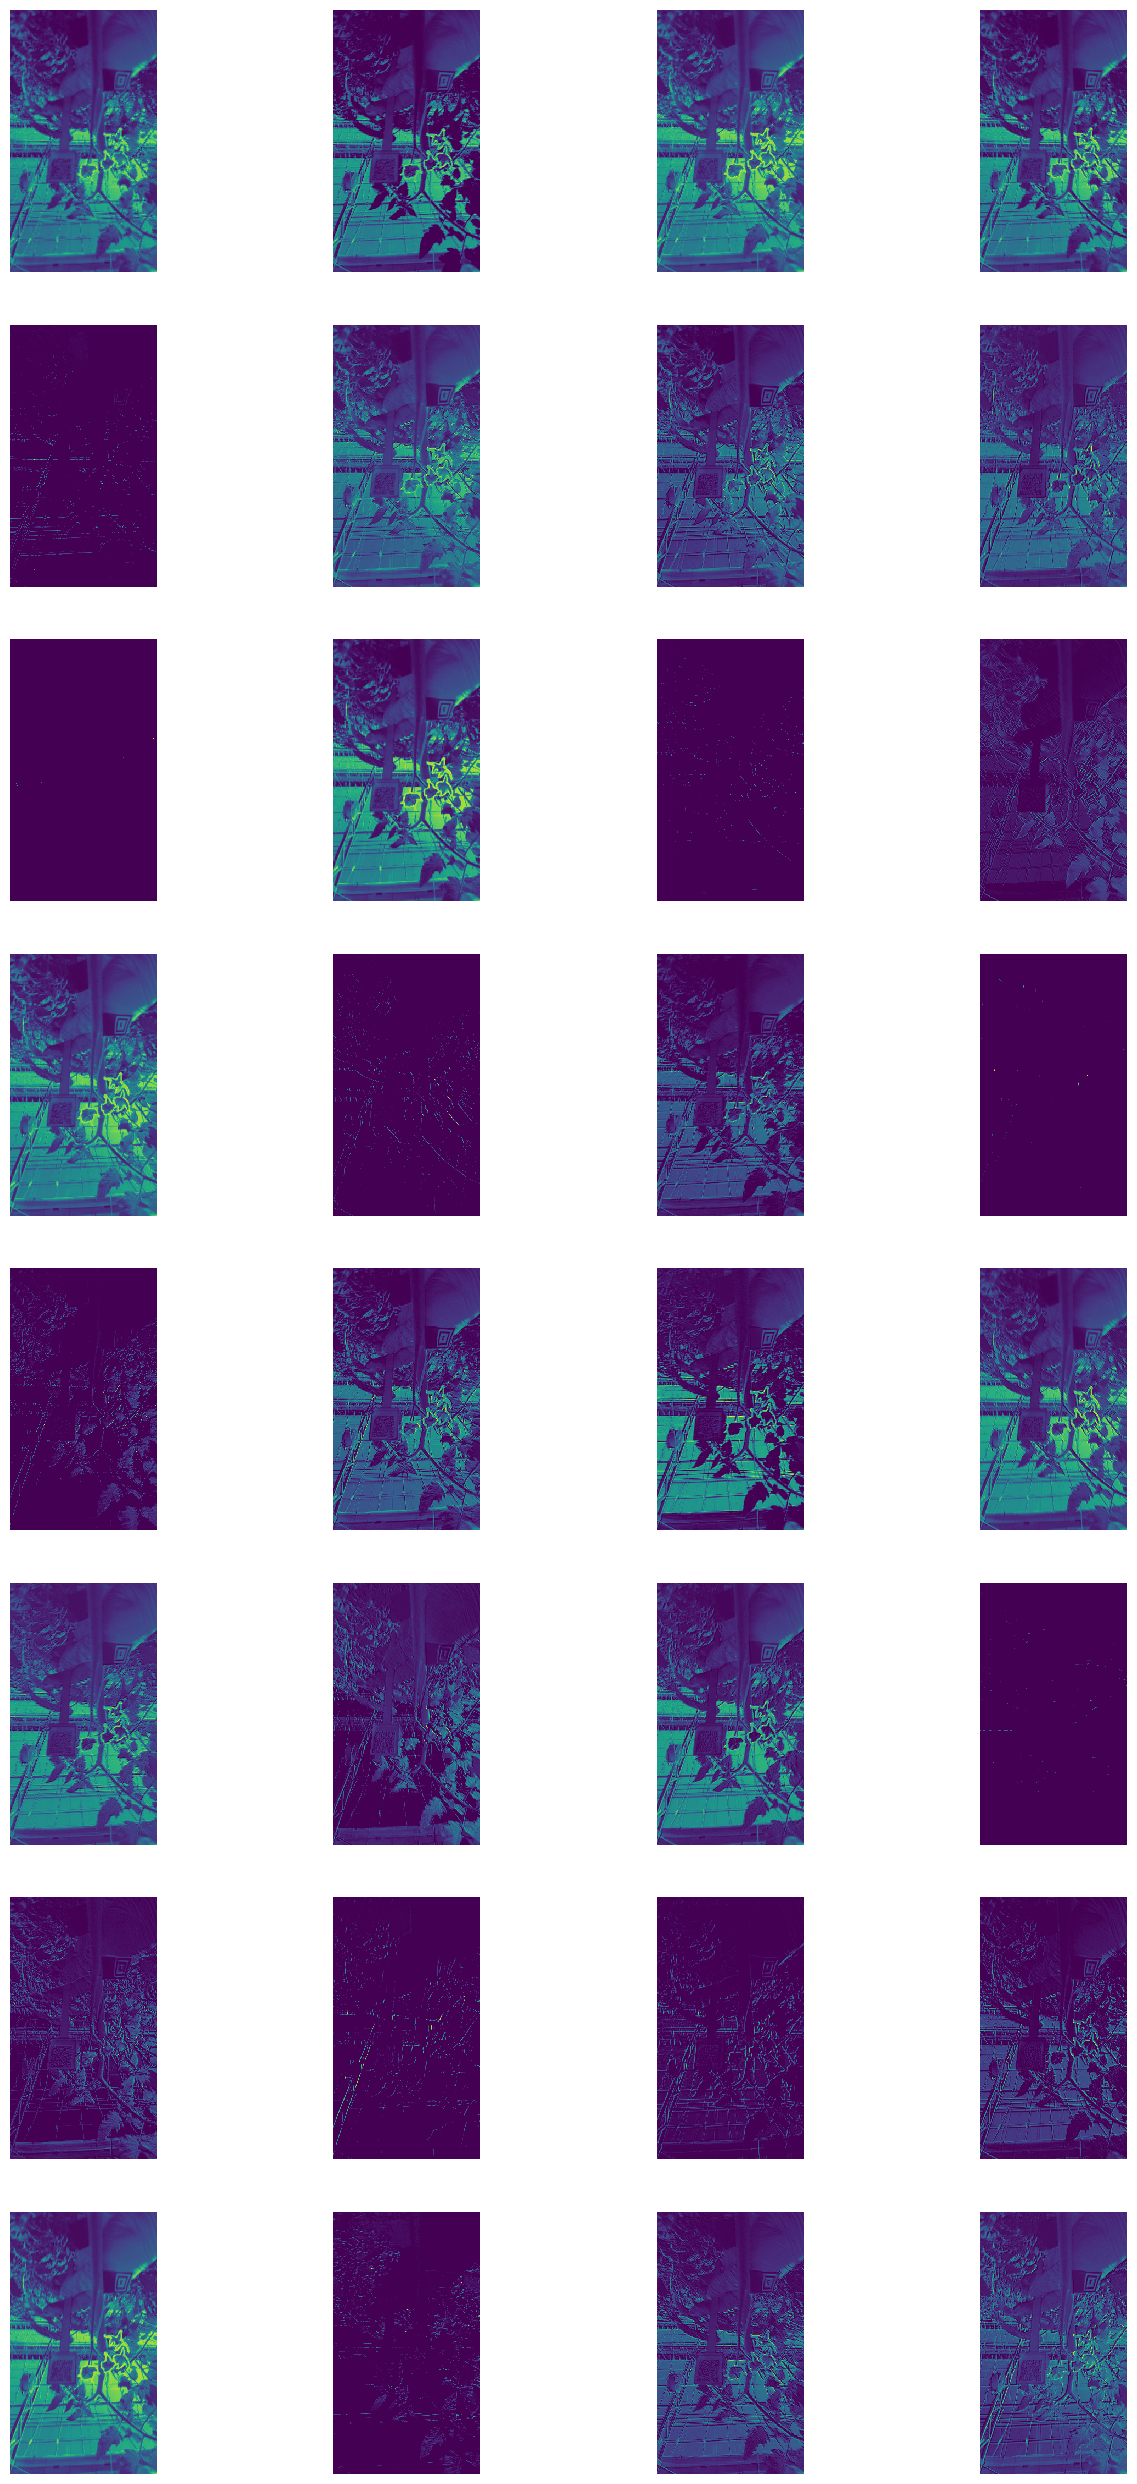

In [18]:
from keras.models import Model
import matplotlib.pyplot as plt

# 중간 레이어의 출력을 추출하기 위한 모델 생성
layer_outputs = [layer.output for layer in model.layers[:1]] 
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# 테스트 이미지 선택
img_tensor = test_images[0.] 
# 이미지 데이터 타입 변경 및 정규화
img_tensor = img_tensor.astype('float32') / 255.0

# 이미지 차원 확장 (모델에 입력하기 위해 필요한 4차원 형태로 변경)
img_tensor = np.expand_dims(img_tensor, axis=0)

# 이미지에 대한 특성 맵 생성
activations = activation_model.predict(img_tensor)

# 첫 번째 레이어의 특성 맵 시각화
first_layer_activation = activations[0]
print(first_layer_activation.shape)

fig, axes = plt.subplots(8, 4, figsize=(16, 32))

for i in range(8):
    for j in range(4):
        ax = axes[i, j]
        ax.matshow(first_layer_activation[:, :, i * 4 + j], cmap='viridis')
        ax.axis('off')

plt.show()

In [43]:
# 테스트 데이터 전처리 함수

def preprocess_test_images(directory, new_size):
    images = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for img_file in files:
            img_path = os.path.join(root, img_file)
            
            img = Image.open(img_path)

            # 원본 이미지의 세로 가로 비율 계산
            ratio = img.height / img.width

            # 원본 비율을 유지하면서 가로축을 기준으로 축소할 크기 계산
            resize_size = (new_size[0], int(new_size[0] * ratio))

            # 원본 이미지를 적절하게 축소
            img = img.resize(resize_size)

            # 축소된 이미지를 원하는 최종 크기로 잘라내기
            upper = (img.size[1] - new_size[1]) / 3
            lower = (img.size[1] + new_size[1]) / 3

            img = img.crop((0, upper, new_size[0], lower))

            img = img.rotate(270)

            img = np.array(img)

            images.append(img)

            if "blossomed_3" in root:
                labels.append(1)
            else:
                labels.append(0)
    
    return np.array(images, dtype=object), np.array(labels)



In [ ]:
# 테스트 데이터 전처리
blossomed_3_directory = "E:\\tomato_data\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\blossomed_3"
blossomed_2_directory = "E:\\tomato_data\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\blossomed_2"
blossomed_1_directory = "E:\\tomato_data\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\TOMATO_BLOOMING_IMAGE_ENV_20231124\\blossomed_1"

test_images_3, test_labels_3 = preprocess_test_images(blossomed_3_directory, new_size)
test_images_2, test_labels_2 = preprocess_test_images(blossomed_2_directory, new_size)
test_images_1, test_labels_1 = preprocess_test_images(blossomed_1_directory, new_size)

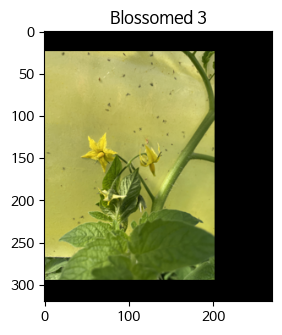

In [42]:
# 테스트 데이터가 전처리가 잘 됐는지 확인하는 코드
# 보고싶은 이미지 출력

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.title('Blossomed 3')
test_images_3_float32 = np.array(test_images_3, dtype=np.float32) / 255.0
plt.imshow(test_images_3_float32[70])

plt.subplot(1, 3, 2)
plt.title('Blossomed 2')
test_images_2_float32 = np.array(test_images_2, dtype=np.float32) / 255.0
plt.imshow(test_images_2_float32[0])

plt.subplot(1, 3, 3)
plt.title('Blossomed 1')
test_images_1_float32 = np.array(test_images_2, dtype=np.float32) / 255.0
plt.imshow(test_images_1_float32[0])

plt.show()

In [13]:
# 모델 예측
predictions_3 = model.predict(test_images_3_float32)
predictions_2 = model.predict(test_images_2_float32)
predictions_1 = model.predict(test_images_1_float32)

23/23 [==============================] - 5s 210ms/step


In [14]:
# 예측 결과를 이진 값으로 변환
predictions_3_binary = (predictions_3 > 0.5).astype("int32")
predictions_2_binary = (predictions_2 > 0.5).astype("int32")
predictions_1_binary = (predictions_1 > 0.5).astype("int32")

In [15]:
# 예측 결과 출력
print("Predictions for 'blossomed_3' images:")
for i, prediction in enumerate(predictions_3_binary):
    print(f"Image {i+1}: {'Blossomed' if prediction == 1 else 'Not blossomed'}")
    
print("Predictions for 'blossomed_2' images:")
for i, prediction in enumerate(predictions_2_binary):
    print(f"Image {i+1}: {'Blossomed' if prediction == 1 else 'Not blossomed'}")

print("\nPredictions for 'blossomed_1' images:")
for i, prediction in enumerate(predictions_1_binary):
    print(f"Image {i+1}: {'Blossomed' if prediction == 1 else 'Not blossomed'}")

Predictions for 'blossomed_3' images:
Image 1: Not blossomed
Image 2: Not blossomed
Image 3: Not blossomed
Image 4: Not blossomed
Image 5: Not blossomed
Image 6: Not blossomed
Image 7: Not blossomed
Image 8: Not blossomed
Image 9: Not blossomed
Image 10: Not blossomed
Image 11: Not blossomed
Image 12: Not blossomed
Image 13: Not blossomed
Image 14: Not blossomed
Image 15: Not blossomed
Image 16: Not blossomed
Image 17: Not blossomed
Image 18: Not blossomed
Image 19: Not blossomed
Image 20: Not blossomed
Image 21: Not blossomed
Image 22: Not blossomed
Image 23: Not blossomed
Image 24: Not blossomed
Image 25: Not blossomed
Image 26: Not blossomed
Image 27: Not blossomed
Image 28: Not blossomed
Image 29: Not blossomed
Image 30: Not blossomed
Image 31: Not blossomed
Image 32: Not blossomed
Image 33: Not blossomed
Image 34: Not blossomed
Image 35: Not blossomed
Image 36: Not blossomed
Image 37: Not blossomed
Image 38: Not blossomed
Image 39: Not blossomed
Image 40: Not blossomed
Image 41: N

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Confusion matrix 
cm_3 = confusion_matrix(test_labels_3, predictions_3_binary)
cm_2 = confusion_matrix(test_labels_2, predictions_2_binary)
#cm_1 = confusion_matrix(test_labels_1, predictions_1_binary)

print("Confusion matrix for 'blossomed_3' images:")
print(cm_3)

print("\nConfusion matrix for 'blossomed_2' images:")
print(cm_2)

#print("\nConfusion matrix for 'blossomed_1' images:")
#print(cm_1)

# Accuracy
accuracy_3 = accuracy_score(test_labels_3, predictions_3_binary)
accuracy_2 = accuracy_score(test_labels_2, predictions_2_binary)
#accuracy_1 = accuracy_score(test_labels_1, predictions_1_binary)

print(f"\nAccuracy for 'blossomed_3' images: {accuracy_3*100:.2f}%")
print(f"\nAccuracy for 'blossomed_2' images: {accuracy_2*100:.2f}%")
#print(f"\nAccuracy for 'blossomed_1' images: {accuracy_1*100:.2f}%")

# Precision
precision_3 = precision_score(test_labels_3, predictions_3_binary)
precision_2 = precision_score(test_labels_2, predictions_2_binary)
#precision_1 = precision_score(test_labels_1, predictions_1_binary)

print(f"\nPrecision for 'blossomed_3' images: {precision_3*100:.2f}%")
print(f"\nPrecision for 'blossomed_2' images: {precision_2*100:.2f}%")
#print(f"\nPrecision for 'blossomed_1' images: {precision_1*100:.2f}%")

# Recall
recall_3 = recall_score(test_labels_3, predictions_3_binary)
recall_2 = recall_score(test_labels_2, predictions_2_binary)
#recall_1 = recall_score(test_labels_1, predictions_1_binary)

print(f"\nRecall for 'blossomed_3' images: {recall_3*100:.2f}%")
print(f"\nRecall for 'blossomed_2' images: {recall_2*100:.2f}%")
#print(f"\nRecall for 'blossomed_1' images: {recall_1*100:.2f}%")

Confusion matrix for 'blossomed_3' images:
[[  0   0]
 [491   0]]

Confusion matrix for 'blossomed_2' images:
[[732]]

Accuracy for 'blossomed_3' images: 0.00%

Accuracy for 'blossomed_2' images: 100.00%

Precision for 'blossomed_3' images: 0.00%

Precision for 'blossomed_2' images: 0.00%

Recall for 'blossomed_3' images: 0.00%

Recall for 'blossomed_2' images: 0.00%


D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
